# 3. Variable Transformation - Maintain

In [1]:
import os

# set dir by hardcode to run in crontab
os.chdir("/home/jacob/Project/LendingClub/")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import warnings
import json

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
def return_files():
    
    # get all list of csv and excel files
    directory = !pwd
    directory = directory[0]
    data_dir = directory + "/Data"
    files = !ls {data_dir}
    files = [f for f in files if ".zip" not in f]

    # divide by type
    dict_file = ["Data/" + f for f in files if "Dict" in f][0]
    training_files = ["Data/" + f for f in files if "LoanStats" in f]
    target_file = ["Data/" + f for f in files if "listed" in f][0]
    
    return dict_file, training_files, target_file

In [3]:
def read_dict_file(dict_file):
    data_dict = pd.read_excel(dict_file).dropna()
    data_dict.set_index('LoanStatNew', inplace=True)
    data_dict.sort_index(inplace=True)
    print("Reading {}..., {}".format(dict_file, data_dict.shape))
    
    return data_dict

In [4]:
# get Quarter
def get_quarter(x): 
    if x.month<=3:
        return "Q1"
    elif x.month<=6:
        return "Q2"
    elif x.month<=9:
        return "Q3"
    else:
        return "Q4"

In [5]:
def transform_training_raw_data(training_file, term):

    # read file
    df = pd.read_csv(training_file, sep=",", skiprows=1)
    df = df[df["term"]== term] #" 36 months"

    # change issue_d to datetime type
    df["issue_d"] = [datetime.datetime.strptime(d, "%b-%Y") for d in df["issue_d"] if type(d) is str]

    issue_Qs = df["issue_d"].map(get_quarter)
    issue_Ys = df["issue_d"].map(lambda x: x.year)
    
    if np.max(issue_Ys) < 2015:
        return pd.DataFrame()

    # get issuance quarter and year 
    df["issue_Q"] = issue_Qs
    df["issue_y"] = issue_Ys
    
    # remove live loans
    df = df[df["loan_status"]!="Current"]
    
    # defined bad loan status
    bad_loans = ["Charged Off", "Default", "In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]

    # True/False if status is bad_loans
    df["bad_loan"] = np.where(df["loan_status"].map(lambda x: x in bad_loans), True, False)

    # change last_pymt_d to maximum date if it is NAN 
    ind = df["last_pymnt_d"].isna() 
    dates = df["issue_d"][ind] + datetime.timedelta(36*30)
    dates = dates.map(lambda x: x.strftime("%b-%Y"))
    df["last_pymnt_d"][ind] = dates

    return df

In [6]:
def get_training_dataset(training_files, term, target_cols, other_cols, verbose = True):
    
    dataset = pd.DataFrame()
    
    for file_name in training_files:
        
        if verbose: print("Reading.. ", file_name)
        df = transform_training_raw_data(file_name, term = " 36 months")
        
        if df.shape == (0,0):
            if verbose: print("..Out of period")
            continue
        
        if verbose: print("..Appending")
        if dataset.shape==(0,0):
            dataset = df
        else:
            dataset = dataset.append(df)
    
    cols = target_cols + other_cols
    dataset = dataset[cols]
    
    return dataset

## a. Load Raw Dataset

In [7]:
# get all variables
with open("Data/variable_selected2.txt", 'r') as f:
    results = json.load(f)
    
info_cols = results["info_cols"]
interim_cols = results["interim_cols"]

info_cols.remove("id")
info_cols.remove("return")
info_cols.remove("log_return")

In [8]:
# get file names
dict_file, training_files, target_file = return_files()

# load raw dataset
term = " 36 months"
df_orig = get_training_dataset(training_files, term, interim_cols, info_cols, verbose=False)

In [9]:
# make a copy of it
df = df_orig.copy()

# get NaN counts by each Quarter
group = df.groupby(["issue_y","issue_Q"]).agg("count")
total = group["bad_loan"]
group = group[interim_cols]
group = group.apply(lambda x: total-x, axis=0)

total_nan = group.sum()
total_nan = total_nan.sort_values()
old_cols = total_nan[total_nan<=df.shape[0]*0.01].index.values
new_cols = total_nan[total_nan>df.shape[0]*0.01].index.values

print(len(old_cols))
print(len(new_cols))

53
31


We have 3 variables which shows < 1% missing data. We can simply remove those in our training, or keep it as NaN in XGBoost.

We also have 12 new variables which are added during Q1 2016. So it might be better to use data from 2016. 

Fiinally, there are a few variables which show lots of missing daa, so we need to think about what to do with those.

In [10]:
display(old_cols)

array(['loan_amnt', 'tax_liens', 'pub_rec_bankruptcies',
       'num_tl_op_past_12m', 'num_tl_90g_dpd_24m', 'num_tl_30dpd',
       'num_sats', 'num_rev_tl_bal_gt_0', 'num_op_rev_tl',
       'total_rev_hi_lim', 'tot_hi_cred_lim', 'num_il_tl', 'num_bc_sats',
       'acc_open_past_24mths', 'num_actv_rev_tl', 'num_actv_bc_tl',
       'num_accts_ever_120_pd', 'chargeoff_within_12_mths', 'delinq_amnt',
       'mort_acc', 'mo_sin_old_rev_tl_op', 'num_bc_tl',
       'mo_sin_rcnt_rev_tl_op', 'tot_cur_bal', 'acc_now_delinq',
       'int_rate', 'installment', 'sub_grade',
       'total_il_high_credit_limit', 'home_ownership', 'annual_inc',
       'verification_status', 'purpose', 'addr_state', 'total_bc_limit',
       'delinq_2yrs', 'earliest_cr_line', 'fico_range_high',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'total_bal_ex_mort', 'total_acc', 'collections_12_mths_ex_med',
       'application_type', 'tot_coll_amt', 'mo_sin_rcnt_tl',
       'num_rev_accts', 'pct_tl_nvr_

In [11]:
group[old_cols].T

issue_y                    2015             2016             2017           \
issue_Q                      Q1  Q2  Q3  Q4   Q1  Q2  Q3  Q4   Q1  Q2   Q3   
loan_amnt                     0   0   0   0    0   0   0   0    0   0    0   
tax_liens                     0   0   0   0    0   0   0   0    0   0    0   
pub_rec_bankruptcies          0   0   0   0    0   0   0   0    0   0    0   
num_tl_op_past_12m            0   0   0   0    0   0   0   0    0   0    0   
num_tl_90g_dpd_24m            0   0   0   0    0   0   0   0    0   0    0   
num_tl_30dpd                  0   0   0   0    0   0   0   0    0   0    0   
num_sats                      0   0   0   0    0   0   0   0    0   0    0   
num_rev_tl_bal_gt_0           0   0   0   0    0   0   0   0    0   0    0   
num_op_rev_tl                 0   0   0   0    0   0   0   0    0   0    0   
total_rev_hi_lim              0   0   0   0    0   0   0   0    0   0    0   
tot_hi_cred_lim               0   0   0   0    0   0   0   0    0   0    0   
num_il_tl                     0   0   0   0    0   0   0   0    0   0    0   
num_bc_sats                   0   0   0   0    0   0   0   0    0   0    0   
acc_open_past_24mths          0   0   0   0    0   0   0   0    0   0    0   
num_actv_rev_tl               0   0   0   0    0   0   0   0    0   0    0   
num_actv_bc_tl                0   0   0   0    0   0   0   0    0   0    0   
num_accts_ever_120_pd         0   0   0   0    0   0   0   0    0   0    0   
chargeoff_within_12_mths      0   0   0   0    0   0   0   0    0   0    0   
delinq_amnt                   0   0   0   0    0   0   0   0    0   0    0   
mort_acc                      0   0   0   0    0   0   0   0    0   0    0   
mo_sin_old_rev_tl_op          0   0   0   0    0   0   0   0    0   0    0   
num_bc_tl                     0   0   0   0    0   0   0   0    0   0    0   
mo_sin_rcnt_rev_tl_op         0   0   0   0    0   0   0   0    0   0    0   
tot_cur_bal                   0   0   0   0    0   0   0   0    0   0    0   
acc_now_delinq                0   0   0   0    0   0   0   0    0   0    0   
int_rate                      0   0   0   0    0   0   0   0    0   0    0   
installment                   0   0   0   0    0   0   0   0    0   0    0   
sub_grade                     0   0   0   0    0   0   0   0    0   0    0   
total_il_high_credit_limit    0   0   0   0    0   0   0   0    0   0    0   
home_ownership                0   0   0   0    0   0   0   0    0   0    0   
annual_inc                    0   0   0   0    0   0   0   0    0   0    0   
verification_status           0   0   0   0    0   0   0   0    0   0    0   
purpose                       0   0   0   0    0   0   0   0    0   0    0   
addr_state                    0   0   0   0    0   0   0   0    0   0    0   
total_bc_limit                0   0   0   0    0   0   0   0    0   0    0   
delinq_2yrs                   0   0   0   0    0   0   0   0    0   0    0   
earliest_cr_line              0   0   0   0    0   0   0   0    0   0    0   
fico_range_high               0   0   0   0    0   0   0   0    0   0    0   
inq_last_6mths                0   0   0   0    0   0   0   0    0   0    0   
open_acc                      0   0   0   0    0   0   0   0    0   0    0   
pub_rec                       0   0   0   0    0   0   0   0    0   0    0   
revol_bal                     0   0   0   0    0   0   0   0    0   0    0   
total_bal_ex_mort             0   0   0   0    0   0   0   0    0   0    0   
total_acc                     0   0   0   0    0   0   0   0    0   0    0   
collections_12_mths_ex_med    0   0   0   0    0   0   0   0    0   0    0   
application_type              0   0   0   0    0   0   0   0    0   0    0   
tot_coll_amt                  0   0   0   0    0   0   0   0    0   0    0   
mo_sin_rcnt_tl                0   0   0   0    0   0   0   0    0   0    0   
num_rev_accts                 0   0   0   1    0   0   0   0    0   0    0   
pct_tl_nvr_dlq        

In [12]:
display(new_cols)

array(['mths_since_recent_bc', 'bc_open_to_buy', 'percent_bc_gt_75',
       'bc_util', 'mo_sin_old_il_acct', 'num_tl_120dpd_2m', 'emp_length',
       'mths_since_recent_inq', 'open_acc_6m', 'open_act_il',
       'open_il_12m', 'total_bal_il', 'open_il_24m', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'inq_fi', 'total_cu_tl',
       'inq_last_12m', 'all_util', 'mths_since_rcnt_il', 'il_util',
       'mths_since_last_delinq', 'mths_since_recent_revol_delinq',
       'mths_since_last_major_derog', 'mths_since_recent_bc_dlq',
       'mths_since_last_record', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'revol_bal_joint'], dtype=object)

In [13]:
group[new_cols].T

issue_y                          2015                        2016         \
issue_Q                            Q1     Q2     Q3     Q4     Q1     Q2   
mths_since_recent_bc              558    610    676    883    800    846   
bc_open_to_buy                    591    644    682    918    854    894   
percent_bc_gt_75                  614    683    772   1019    871    898   
bc_util                           632    685    740    973    909    930   
mo_sin_old_il_acct               2135   2296   2579   2952   3058   2418   
num_tl_120dpd_2m                 1741   2534   4792   5168   5148   3272   
emp_length                       3715   3806   4983   6466   7348   5478   
mths_since_recent_inq            5893   6966   8286  10106  10244   7942   
open_acc_6m                     56569  64222  73572  73874     44      0   
open_act_il                     56569  64222  73572  73874     44      0   
open_il_12m                     56569  64222  73572  73874     44      0   
total_bal_il                    56569  64222  73572  73874     44      0   
open_il_24m                     56569  64222  73572  73874     44      0   
open_rv_12m                     56569  64222  73572  73874     44      0   
open_rv_24m                     56569  64222  73572  73874     44      0   
max_bal_bc                      56569  64222  73572  73874     44      0   
inq_fi                          56569  64222  73572  73874     44      0   
total_cu_tl                     56569  64222  73572  73874     44      0   
inq_last_12m                    56569  64222  73572  73874     44      0   
all_util                        56569  64222  73572  73874     50      4   
mths_since_rcnt_il              56569  64222  73572  74339   3097   2418   
il_util                         56569  64222  73572  75946  13876  10889   
mths_since_last_delinq          27135  30731  35600  42425  45821  35310   
mths_since_recent_revol_delinq  35844  40569  46869  56382  61283  47403   
mths_since_last_major_derog     39677  44873  51272  61819  68146  53224   
mths_since_recent_bc_dlq        41546  47186  54575  65776  71548  55442   
mths_since_last_record          46108  52085  59757  72365  78614  60264   
annual_inc_joint                56569  64222  73572  88571  94592  73666   
dti_joint                       56569  64222  73572  88572  94594  73666   
verification_status_joint       56569  64222  73572  88571  94592  73666   
revol_bal_joint                 56569  64222  73572  88810  96120  74537   

issue_y                                        2017                       \
issue_Q                            Q3     Q4     Q1     Q2     Q3     Q4   
mths_since_recent_bc              865   1028    756    870   1257   1115   
bc_open_to_buy                    917   1091    787    911   1332   1187   
percent_bc_gt_75                  920   1092    788    913   1333   1191   
bc_util                           947   1127    816    949   1376   1221   
mo_sin_old_il_acct               2286   2319   2220   2195   2901   2876   
num_tl_120dpd_2m                 2258   3869   3205   3439   3378   3702   
emp_length                       4867   5809   5681   5470   6753   6210   
mths_since_recent_inq            7724   9255   8758   8898  10200   8836   
open_acc_6m                         0      0      0      0      0      0   
open_act_il                         0      0      0      0      0      0   
open_il_12m                         0      0      0      0      0      0   
total_bal_il                        0      0      0      0      0      0   
open_il_24m                         0      0      0      0      0      0   
open_rv_12m                         0      0      0      0      0      0   
open_rv_24m                         0      0      0      0      0      0   
max_bal_bc                          0      0      0      0      0      0   
inq_fi                              0      0      0      0      0      0   
total_cu_tl                         0      0   

### Divide variables based on missing data

In [14]:
df_orig = df_orig[df_orig["issue_y"]>2015]
df = df_orig.copy()

In [15]:
# make a copy of it
df = df_orig.copy()

# get NaN counts by each Quarter
group = df.groupby(["issue_y","issue_Q"]).agg("count")
total = group["bad_loan"]
group = group[interim_cols]
group = group.apply(lambda x: total-x, axis=0)

total_nan = group.sum()
total_nan = total_nan.sort_values()
old_cols = total_nan[total_nan<=df.shape[0]*0.01].index.values
new_cols = total_nan[total_nan>df.shape[0]*0.01].index.values

print(len(old_cols))
print(len(new_cols))

65
19


In [16]:
# sort by name
old_cols, new_cols = sorted(old_cols), sorted(new_cols)

## b. Check variables without significant missing data

In [17]:
def temp_transform(df, trans_map):
    
    for col, method in trans_map.items(): 
        if method == "log":
            df[col] = np.log(df[col])
        elif method == "1+log":
            df[col] = np.log(1+df[col])
        elif method == "sqrt":
            df[col] = np.sqrt(df[col])
    
    return df       

In [18]:
def temp_cut(df, cut_map):
    for col, cut in cut_map.items():   
        if not np.isnan(cut):
            df[col][df[col]>=cut] = cut
    return df     

In [19]:
def temp_fill(df, fill_map):
    for col, fill in fill_map.items():
        if not np.isnan(fill):
            df[col].fillna(fill, inplace=True)
    return df

In [20]:
def show_summary_stat(summary, df, i, j, glossary, plot_only=False):
    
    part = summary.iloc[:,i:j]
    if not plot_only: display(part.T)
    
    cols = 3
    rows = np.ceil((j-i)/cols)
    
    fig = plt.figure(figsize=(12,12))
    n = 1
    for col in part.columns.values:
        
        if not plot_only: 
            try:
                print(col, ": ", glossary.loc[col].values[0])
            except:
                print(col, ": ", "no info available")

        ax = fig.add_subplot(rows, cols, n)
        ax.hist(df[col])
        ax.set_title(col)
        n += 1
    
    fig.show()

In [21]:
def show_summary_stat_bycols(summary, df, colnames, glossary, plot_only=False):
    
    part = summary[colnames]
    if not plot_only: display(part.T)
    
    cols = 3
    rows = np.ceil(len(colnames)/cols)
    
    fig = plt.figure(figsize=(12,12))
    n = 1
    for col in part.columns.values:
        
        if not plot_only: 
            try:
                print(col, ": ", glossary.loc[col].values[0])
            except:
                print(col, ": ", "no info available")

        ax = fig.add_subplot(rows, cols, n)
        ax.hist(df[col])
        ax.set_title(col)
        n += 1
    
    fig.show()

In [22]:
def show_badloans_by_catvars(df, col):
    
    temp_count = df[["bad_loan", col]].groupby([col]).agg("sum")
    temp_total = df[["bad_loan", col]].groupby([col]).agg("count")
    temp = temp_count/temp_total
    temp["count"] = temp_total
    temp.sort_values(by="count")
    return temp

In [23]:
# get summary
summary = df[old_cols].describe()

# add missing value counts
total = df.shape[0]
row = summary.apply(lambda x: total-x["count"], axis=0)
row = pd.Series(row, name="Nan")

summary = summary.append(row)

Before we jump on, note that there are 11 variabes with special format, which cannot be "Described". We need to take a separate look for these.

In [24]:
# need to check separately these guys
left_cols = [c for c in old_cols if c not in summary.columns.values]
display(df[left_cols].head().T)
print(len(left_cols))

,1,2,8,9,10
addr_state,CA,NC,AR,NC,OH
application_type,Individual,Individual,Individual,Individual,Individual
earliest_cr_line,Mar-1980,Aug-1999,May-2009,Nov-1988,Mar-1985
home_ownership,RENT,OWN,RENT,RENT,RENT
int_rate,6.49%,6.49%,5.32%,12.99%,10.75%
purpose,debt_consolidation,credit_card,home_improvement,debt_consolidation,debt_consolidation
revol_util,37.8%,47.3%,11%,58.4%,53.1%
sub_grade,A2,A2,A1,C2,B4
verification_status,Source Verified,Not Verified,Source Verified,Source Verified,Verified


9


Let's treat for these 9 variables first!

In [25]:
df = df_orig.copy()

In [26]:
# state!! - combine to "Other", using all 50 states will overfit
temp = show_badloans_by_catvars(df, "addr_state")
states = temp[temp["count"] >= 20000].index.values
print(states)

['AZ' 'CA' 'FL' 'GA' 'IL' 'MA' 'MD' 'MI' 'NC' 'NJ' 'NY' 'OH' 'PA' 'TX'
 'VA']


In [27]:
df["addr_state"] = df["addr_state"].map(lambda x: "Other" if x not in states else x)

In [28]:
show_badloans_by_catvars(df, "addr_state")

,bad_loan,count
addr_state,,
AZ,0.167827,23405
CA,0.182110,129647
FL,0.201520,70266
GA,0.166740,29723
IL,0.155579,36631
MA,0.175355,20986
MD,0.187601,21050
MI,0.164341,24151
NC,0.170299,25285


In [29]:
# application type - nothing to do
df.groupby("application_type").agg("count")["sub_grade"]

application_type
Individual    866024
Joint App      61406
Name: sub_grade, dtype: int64

In [30]:
df["application_type"] = np.where(df["application_type"] == "Individual", 1, 0)
df.groupby("application_type").agg("count")["sub_grade"]

application_type
0     61406
1    866024
Name: sub_grade, dtype: int64

In [31]:
# earliest_cr_line - change to days until issue_d and log trans
df["earliest_cr_line"] = df["earliest_cr_line"].map(lambda x: datetime.datetime.strptime(x, "%b-%Y"))
delta = df["issue_d"] - df["earliest_cr_line"]
delta = delta.map(lambda x: x.days)
df["earliest_cr_line"] = delta 

In [32]:
# home_ownership
show_badloans_by_catvars(df, "home_ownership")

,bad_loan,count
home_ownership,,
ANY,0.213502,1185
MORTGAGE,0.141518,425642
NONE,0.000000,3
OWN,0.184598,116150
RENT,0.207676,384450


In [33]:
# change NONE to ANY
df.loc[df["home_ownership"] == "NONE", "home_ownership"] = "ANY"
show_badloans_by_catvars(df, "home_ownership")

,bad_loan,count
home_ownership,,
ANY,0.212963,1188
MORTGAGE,0.141518,425642
OWN,0.184598,116150
RENT,0.207676,384450


In [34]:
# int_rate - change it to double
df["int_rate"] = df["int_rate"].map(lambda x: np.float32(x.split("%")[0])/100) # change interest format
df["int_rate"] = list(map(float, df["int_rate"]))

In [35]:
# Purpose 
show_badloans_by_catvars(df, "purpose")

,bad_loan,count
purpose,,
car,0.131127,11874
credit_card,0.160076,208413
debt_consolidation,0.182468,491389
educational,0.000000,1
home_improvement,0.148956,67765
house,0.196135,6934
major_purchase,0.158661,23774
medical,0.188557,14664
moving,0.203486,8261


In [36]:
df.loc[df["purpose"]=="educational", "purpose"] = "other" 
df.loc[df["purpose"]=="renewable_energy", "purpose"] = "other" 
df.loc[df["purpose"]=="wedding", "purpose"] = "other" 

In [37]:
show_badloans_by_catvars(df, "purpose")

,bad_loan,count
purpose,,
car,0.131127,11874
credit_card,0.160076,208413
debt_consolidation,0.182468,491389
home_improvement,0.148956,67765
house,0.196135,6934
major_purchase,0.158661,23774
medical,0.188557,14664
moving,0.203486,8261
other,0.178521,74462


In [38]:
# do not touch the grade

In [39]:
# revol_util - change it to double
df.loc[df["revol_util"].notna(),"revol_util"] = df.loc[df["revol_util"].notna(),"revol_util"].map(lambda x: np.float32(x.split("%")[0])/100) # change ratio format
df["revol_util"] = list(map(float, df["revol_util"]))

In [65]:
# verification_status
df.loc[df["verification_status"]=="Verified", "verification_status"] = "VERIFIED"
df.loc[df["verification_status"]=="Source Verified", "verification_status"] = "SOURCE_VERIFIED"
df.loc[df["verification_status"]=="Not Verified", "verification_status"] = "NOT_VERIFIED"
show_badloans_by_catvars(df, "verification_status")

,bad_loan,count
verification_status,,
NOT_VERIFIED,0.144589,331734
SOURCE_VERIFIED,0.178362,380485
VERIFIED,0.213474,215211


Read the dictionary file.

In [41]:
glossary = read_dict_file(dict_file)

Reading Data/LCDataDictionary.xlsx..., (151, 1)


## b. Check variables with significant missing data

In [42]:
# get summary
summary = df[new_cols].describe()

# add missing value counts
total = df.shape[0]
row = summary.apply(lambda x: total-x["count"], axis=0)
row = pd.Series(row, name="Nan")

summary = summary.append(row)

In [43]:
# need to check separately these guys
left_cols = [c for c in new_cols if c not in summary.columns.values]
display(df[left_cols].head().T)
print(len(left_cols))

,1,2,8,9,10
emp_length,10+ years,5 years,NaN,10+ years,10+ years
verification_status_joint,NaN,NaN,NaN,NaN,NaN


2


In [44]:
# emp_length
show_badloans_by_catvars(df, "emp_length")

,bad_loan,count
emp_length,,
1 year,0.181065,64176
10+ years,0.152795,292332
2 years,0.173027,87148
3 years,0.175131,76343
4 years,0.175363,57475
5 years,0.172826,57416
6 years,0.164500,40146
7 years,0.167418,31944
8 years,0.165117,32165


In [45]:
# emp_length
def emp_filter(x):
    if "<" in x:
        x = int(x[2])
    else:
        x = x.split(" ")[0].split("+")[0]
        x = int(x)+1
    
    return(x)

ind = (df["emp_length"].isna()==0)
df["emp_length"][ind] = df["emp_length"][ind].map(emp_filter) # change interest format

In [46]:
# emp_length
show_badloans_by_catvars(df, "emp_length")

,bad_loan,count
emp_length,,
1,0.192444,84466
2,0.181065,64176
3,0.173027,87148
4,0.175131,76343
5,0.175363,57475
6,0.172826,57416
7,0.164500,40146
8,0.167418,31944
9,0.165117,32165


In [67]:
# verification_status
df.loc[df["verification_status_joint"]=="Verified", "verification_status_joint"] = "VERIFIED"
df.loc[df["verification_status_joint"]=="Source Verified", "verification_status_joint"] = "SOURCE_VERIFIED"
df.loc[df["verification_status_joint"]=="Not Verified", "verification_status_joint"] = "NOT_VERIFIED"
show_badloans_by_catvars(df, "verification_status_joint")

,bad_loan,count
verification_status_joint,,
NOT_VERIFIED,0.170555,30518
SOURCE_VERIFIED,0.235868,17319
VERIFIED,0.233665,11264


## c. Check entire variables

In [48]:
cols = old_cols + new_cols

Read the container for transform information

In [49]:
with open("Data/transform_map.txt", 'r') as f:
    results = json.load(f)

In [50]:
transform_map = results["transform"]
cut_map = results["cut"]
fill_map = results["fill"]

transform = pd.DataFrame({"transform" : transform_map, "cut" : cut_map, "fill" : fill_map})

Check what we are missing so far.

In [51]:
vars_not_captured = []
for var in cols:
    if var not in transform.index.values:
        print(var)
        vars_not_captured.append(var)

fico_range_high
verification_status
annual_inc_joint
dti_joint
revol_bal_joint
verification_status_joint


In [52]:
for var in vars_not_captured:
    transform_map[var] = np.nan
    cut_map[var] = np.nan
    fill_map[var] = np.nan

In [53]:
# so log transform is needed
transform_map["fico_range_high"] = "log"
transform_map["annual_inc_joint"] = "1+log"
transform_map["dti_joint"] = "1+log"
transform_map["revol_bal_joint"] = "1+log"

Not let's see how are the variables look like after transform.

In [54]:
df = temp_transform(df, transform_map)
df = temp_cut(df, cut_map)
df = temp_fill(df, fill_map)

In [55]:
# get summary
summary = df[cols].describe()

# add missing value counts
total = df.shape[0]
row = summary.apply(lambda x: total-x["count"], axis=0)
row = pd.Series(row, name="Nan")

summary = summary.append(row)

,count,mean,std,min,25%,50%,75%,max,Nan
annual_inc_joint,61406.0,11.596934,0.481357,8.647258,11.289794,11.599112,11.898195,14.566927,866024.0
dti_joint,61404.0,2.882147,0.483023,0.000000,2.623944,2.954129,3.228034,4.255471,866026.0
revol_bal_joint,54128.0,9.985948,0.991838,0.000000,9.484747,10.081927,10.618366,13.596089,873302.0


annual_inc_joint :  The combined self-reported annual income provided by the co-borrowers during registration
dti_joint :  A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income
revol_bal_joint :  no info available


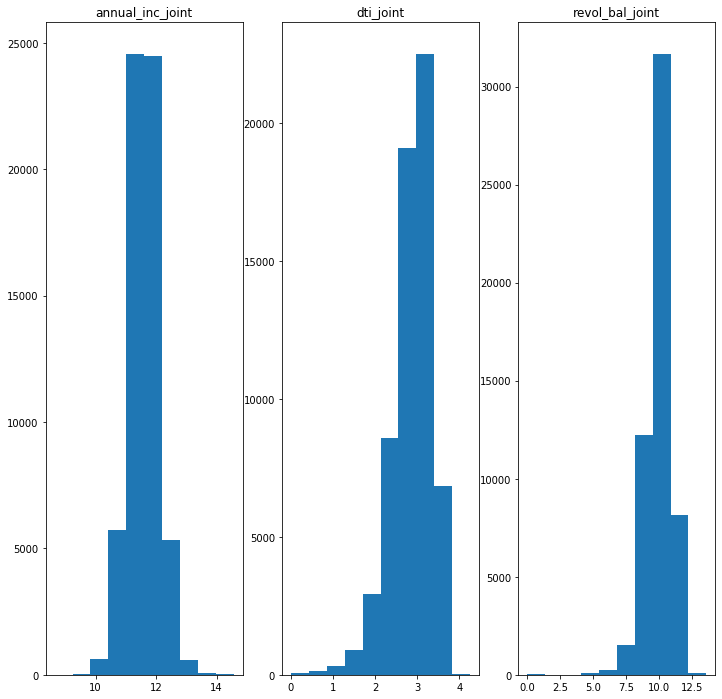

In [56]:
show_summary_stat_bycols(summary, df, ["annual_inc_joint", "dti_joint", "revol_bal_joint"], glossary)

## d. Save the results

In [57]:
results = {}
results["transform"] = transform_map
results["cut"] = cut_map
results["fill"] = fill_map

In [58]:
with open("Data/transform_map2.txt", 'w') as f:
    json.dump(results, f)

In [59]:
transform_map = results["transform"]
cut_map = results["cut"]
fill_map = results["fill"]

transform = pd.DataFrame({"transform" : transform_map, "cut" : cut_map, "fill" : fill_map})
transform

,transform,cut,fill
acc_now_delinq,NaN,2.0,NaN
acc_open_past_24mths,NaN,20.0,NaN
addr_state,NaN,NaN,NaN
all_util,1+log,NaN,NaN
annual_inc,1+log,NaN,NaN
annual_inc_joint,1+log,NaN,NaN
application_type,NaN,NaN,NaN
avg_cur_bal,1+log,NaN,NaN
bc_open_to_buy,1+log,NaN,NaN
bc_util,1+log,NaN,NaN
